In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A
import glob
from shapely.geometry import Polygon


/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 45em; }</style>"))
pd.options.display.max_columns = None

/tmp/ipykernel_31837/2198079538.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(300, 32),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [4]:
model = VGG_model()
model.load_state_dict(torch.load('./Model_VGG_4_5_2000_13080_epoch'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [5]:
def predict_keypoints(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    img_normalised = img_normalised.to(device)
    
    key_points = model(img_normalised[None]).flatten().detach().cpu().numpy()
    
    return key_points

In [6]:
def plot_keypoints(img, keypoints):                                                             

    plt.imshow(img)

    keypoints = np.array(keypoints)
    
    x_points = keypoints[0::2]
    y_points = keypoints[1::2]
    
    plt.scatter(x_points*img.shape[1], y_points*img.shape[0], s = 4, c=(1,0,0))
    plt.show()

In [7]:
def process_num(x):
    return x*random.uniform(0.95, 1.05)

In [8]:
def process_label(x):
    string_to_int_dict = {'orange':0, 'pear':1, 'banana':2, 'plum':3, 'egg':4, 'strawberry':5, 'chicken':6, 'bayberry':7, 'redgrape':8, 'pistachio':9}
    return string_to_int_dict[x]


In [9]:
def transform_image(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    return img_normalised

In [10]:
def augment_data():

    source_folder = os.path.join(os. getcwd(), 'Grasp_dataset_2')
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    for f in dataset_names:
        
        files = glob.glob(destination_folder + '/' + f + '/*')
        
        for file in files:
            os.remove(file)
        
        df = pd.read_csv(source_folder + '/' + f + '/' + f + '.csv')
        
        num_cols = df.select_dtypes(include=['float']).columns
        df[num_cols] = df[num_cols].applymap(process_num)
        df['label'] = df['label'].apply(process_label)
        
#         df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)
        
        i = 0
        repeat = 0
        
        header = ['p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y',
              'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x',
              'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y']
            
        keypoints_df = pd.DataFrame(columns=header)
        
        while i < df.shape[0]:
        
            transform = A.Compose([
                    A.Affine(rotate=random.uniform(-1, 1), p=1),
                    A.Affine(translate_percent={'x': random.uniform(-0.02, 0.02), 'y': random.uniform(-0.02, 0.02)}, p=1),
                    A.Affine(shear={'x': random.uniform(-1, 1), 'y': random.uniform(-0.5, 0.5)}, p=1),
                    A.Affine(scale=(0.98, 1.01), p=1)
                ], keypoint_params=A.KeypointParams(format='xy'))
            
            image_to_be_transformed = cv2.imread(os.path.join(source_folder + '/' + f, df.iloc[i]['image_name']))
            
            processed_image_to_be_transformed = transform_image(image_to_be_transformed)
            processed_image_to_be_transformed = processed_image_to_be_transformed.to(device)

            keypoints = model(processed_image_to_be_transformed[None]).flatten().detach().cpu().numpy()
            
            x_points = keypoints[0::2]
            y_points = keypoints[1::2]
            x_points = x_points*image_to_be_transformed.shape[1]
            y_points = y_points*image_to_be_transformed.shape[0]

            transformed = transform(image=image_to_be_transformed, keypoints=list(zip(x_points, y_points)))
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
            
            if repeat >= 20:
                print('skipping')
                repeat = 0
                i = i + 1
                continue
    
            if len(transformed_keypoints) != 16:
#                 print(df.iloc[i]['image_name'])
                repeat = repeat + 1
                continue
            
            flatten_coordinates = np.array(transformed_keypoints).flatten()
            flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
            flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
            keypoints_df.loc[len(keypoints_df)] = pd.Series(flatten_coordinates, index=header)
#             print(flatten_coordinates)
#             print(keypoints_df)
            
#             transformed_image[..., [0, 2]] = transformed_image[..., [2, 0]]
#             img = Image.fromarray(np.uint8(transformed_image))
#             img.save(destination_folder + '/' + f + '/' + df.iloc[i]['image_name'])
            
#             plot_keypoints(transformed_image, flatten_coordinates)
            
            repeat = 0
            i = i + 1
        
        complete_df = pd.concat([df, keypoints_df], axis=1)
        complete_df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)


In [ ]:
# test_image = cv2.imread('/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Grasp_dataset_augmented/Grasp_dataset_orange/Gimage10.jpg')
# test_keypoints = [0.12771776,0.2779994,0.47523814,0.025530297,0.8148705,0.2775899,0.8246956,0.62812585,0.49508992,0.9256545,0.15821105,0.73071223,0.43649036,0.20082472,0.40966305,0.36028758,0.39995593,0.49125895,0.41422606,0.61616457,0.44915825,0.75999326,0.52863693,0.7681227,0.5525919,0.6140371,0.5610489,0.49106207,0.5443897,0.3638414,0.51417565,0.20984803]
# print(len(test_keypoints))
# plot_keypoints(test_image, test_keypoints)

In [11]:
def combine_datasets():

    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    complete_df_set = pd.DataFrame()
    first_dataset = True

    for f in dataset_names:

        df = pd.read_csv(destination_folder + '/' + f + '/' + f + '.csv')

        if first_dataset == True:
            complete_df_set = df
            first_dataset = False
        else:
            complete_df_set = pd.concat([complete_df_set, df], axis=0)

    complete_df_set.to_csv(destination_folder + '/' + 'Grasp_dataset_augmented.csv', index=False)


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# augment_data()
# combine_datasets()

# grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')

# print(grasp_dataset.tail(2))


# data_train, data_test, label_train, label_test = train_test_split(grasp_data, grasp_label, test_size=0.2, random_state=np.random.randint(100))

# clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=np.random.randint(100))

# num_folds = 10
# cv_method = KFold(n_splits=num_folds, shuffle=True, random_state=np.random.randint(100))
# cv_results = cross_val_score(clf, grasp_data, grasp_label, cv=cv_method, scoring='accuracy')

# print('Cross-validation results:', cv_results)
# print('Average accuracy:', cv_results.mean())


In [12]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data, self.label = self.clean_data(df)
        
        
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        label = self.label.iloc[idx]
        label = F.one_hot(torch.tensor(label), 10)
        
        return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
    
    def __len__(self):
        return self.data.shape[0]

    
    def clean_data(self, grasp_dataset):
        grasp_data = grasp_dataset.drop(columns=['image_name', 'label'], axis=1)
        grasp_data['pressure_reading_1'] = grasp_data['pressure_reading_1'] / 100
        grasp_data['pressure_reading_2'] = grasp_data['pressure_reading_2'] / 100
        grasp_data['force_reading_1'] = grasp_data['force_reading_1'] / 1000
        grasp_data['force_reading_2'] = grasp_data['force_reading_2'] / 1000
        grasp_label = grasp_dataset['label']

        return grasp_data, grasp_label

In [106]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(16*2+4, 32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.layers(x)



In [107]:
classification_model = MLP()
classification_model = classification_model.to(device)

In [108]:
summary(classification_model, (8,16*2+4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 8, 32]           1,184
         LeakyReLU-2                [-1, 8, 32]               0
           Dropout-3                [-1, 8, 32]               0
            Linear-4                [-1, 8, 10]             330
Total params: 1,514
Trainable params: 1,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [109]:
def update_training_set():

    global train_df, test_df, train_dataset, test_dataset, train_dataloader, test_dataloader, image_data
    
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')

    augment_data()
    combine_datasets()
    
    grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')
    
    train_df, test_df = train_test_split(grasp_dataset, test_size=0.1)
    
    train_dataset = ClassifierDataset(train_df)
    test_dataset = ClassifierDataset(test_df)
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
    
    print('Finished.')

In [101]:
update_training_set()

Finished.


In [110]:
def get_essentials():
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [111]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    input_data, target_output = data
    pred_output = model(input_data)
    loss = loss_fun(pred_output, target_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    input_data, target_output = data
    pred_output = model(input_data.to(torch.float32))
    loss = loss_fun(pred_output, target_output)
    return loss.item()


In [112]:
epochs = 1000
loss_fun, optimizer = get_essentials()

In [113]:
train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, classification_model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)
    for data in test_dataloader:
        val_batch_loss = val_batch(data, classification_model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

    if epoch % 5 == 0:
        print(train_batch_loss, val_batch_loss)
    
    if (epoch) % 100 == 0:
        torch.save(classification_model.state_dict(), './Temp_models/Model_classify_dataset_2' + str(epoch) + '_epoch')
        update_training_set()

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)


2.1973929405212402 2.349520683288574


  0%|                                        | 1/1000 [00:09<2:44:19,  9.87s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
  0%|                                        | 2/1000 [00:09<1:08:35,  4.12s/it]

Finished.


  1%|▎                                         | 8/1000 [00:10<09:26,  1.75it/s]

2.2014379501342773 2.3184447288513184


  1%|▍                                        | 12/1000 [00:10<04:51,  3.39it/s]

2.2621493339538574 2.2775492668151855


  2%|▋                                        | 18/1000 [00:11<02:36,  6.26it/s]

2.270634651184082 2.2904295921325684


  2%|▉                                        | 22/1000 [00:11<02:02,  7.98it/s]

2.360264778137207 2.256232500076294


  3%|█▏                                       | 28/1000 [00:12<01:43,  9.43it/s]

2.1660518646240234 2.2577710151672363


  3%|█▎                                       | 32/1000 [00:12<01:38,  9.79it/s]

2.315410614013672 2.2682251930236816


  4%|█▌                                       | 38/1000 [00:13<01:35, 10.09it/s]

2.168529510498047 2.2615749835968018


  4%|█▋                                       | 42/1000 [00:13<01:33, 10.27it/s]

2.256502866744995 2.2843523025512695


  5%|█▉                                       | 48/1000 [00:14<01:33, 10.23it/s]

2.2561216354370117 2.2339494228363037


  5%|██▏                                      | 52/1000 [00:14<01:30, 10.43it/s]

2.2836647033691406 2.2179298400878906


  6%|██▍                                      | 58/1000 [00:15<01:31, 10.31it/s]

2.1418251991271973 2.1284968852996826


  6%|██▌                                      | 62/1000 [00:15<01:30, 10.42it/s]

1.7957547903060913 2.2289881706237793


  7%|██▊                                      | 68/1000 [00:16<01:30, 10.34it/s]

2.17147159576416 2.2598466873168945


  7%|██▉                                      | 72/1000 [00:16<01:30, 10.27it/s]

2.3376340866088867 2.2648091316223145


  8%|███                                      | 76/1000 [00:17<01:32, 10.03it/s]

2.2048401832580566 2.022739887237549


  8%|███▎                                     | 82/1000 [00:17<01:34,  9.68it/s]

2.1847147941589355 1.8378405570983887


  9%|███▌                                     | 86/1000 [00:18<01:32,  9.87it/s]

2.028351068496704 1.6766413450241089


  9%|███▊                                     | 92/1000 [00:18<01:32,  9.81it/s]

2.173144817352295 1.9663119316101074


 10%|███▉                                     | 97/1000 [00:19<01:29, 10.10it/s]

1.3972268104553223 2.2343530654907227


 10%|████                                     | 99/1000 [00:19<01:31,  9.88it/s]

1.9705448150634766 2.0060157775878906


 10%|████                                    | 101/1000 [00:29<27:21,  1.83s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 10%|████                                    | 103/1000 [00:29<18:48,  1.26s/it]

Finished.


 11%|████▎                                   | 107/1000 [00:30<09:31,  1.56it/s]

1.7889227867126465 1.5880059003829956


 11%|████▍                                   | 112/1000 [00:30<04:37,  3.20it/s]

1.6197237968444824 1.891142725944519


 12%|████▋                                   | 118/1000 [00:31<02:13,  6.61it/s]

2.052032709121704 1.8077528476715088


 12%|████▉                                   | 122/1000 [00:31<01:47,  8.13it/s]

1.7958052158355713 1.8760544061660767


 13%|█████                                   | 128/1000 [00:32<01:32,  9.42it/s]

1.3488720655441284 1.331416130065918


 13%|█████▎                                  | 132/1000 [00:32<01:28,  9.84it/s]

1.6734589338302612 1.7204453945159912


 14%|█████▌                                  | 138/1000 [00:33<01:26,  9.98it/s]

1.3399900197982788 1.9555487632751465


 14%|█████▋                                  | 142/1000 [00:33<01:28,  9.69it/s]

1.817359209060669 1.1503539085388184


 15%|█████▉                                  | 148/1000 [00:34<01:25,  9.93it/s]

1.7637813091278076 1.5709989070892334


 15%|██████                                  | 153/1000 [00:34<01:25,  9.92it/s]

2.075057029724121 1.3594202995300293


 16%|██████▎                                 | 157/1000 [00:35<01:25,  9.83it/s]

0.8644399642944336 1.3665225505828857


 16%|██████▍                                 | 162/1000 [00:35<01:27,  9.54it/s]

1.6985361576080322 1.7048423290252686


 17%|██████▋                                 | 167/1000 [00:36<01:25,  9.77it/s]

2.039105176925659 1.079225778579712


 17%|██████▉                                 | 172/1000 [00:36<01:26,  9.58it/s]

2.2473549842834473 1.5340791940689087


 18%|███████                                 | 178/1000 [00:37<01:23,  9.79it/s]

0.7274056673049927 1.690018653869629


 18%|███████▎                                | 182/1000 [00:37<01:22,  9.87it/s]

1.683736801147461 1.5550092458724976


 19%|███████▍                                | 187/1000 [00:38<01:23,  9.71it/s]

2.055213212966919 1.9582486152648926


 19%|███████▋                                | 192/1000 [00:39<01:23,  9.66it/s]

1.215024471282959 1.812326192855835


 20%|███████▉                                | 197/1000 [00:39<01:23,  9.65it/s]

1.5857698917388916 1.3086967468261719


 20%|████████                                | 200/1000 [00:39<01:23,  9.57it/s]

1.801865816116333 1.2021806240081787


 20%|████████                                | 201/1000 [00:50<42:24,  3.18s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 20%|████████                                | 202/1000 [00:50<30:05,  2.26s/it]

Finished.


 21%|████████▎                               | 207/1000 [00:50<06:13,  2.12it/s]

1.6542253494262695 1.6922093629837036


 21%|████████▍                               | 212/1000 [00:51<02:12,  5.94it/s]

1.630014181137085 1.4084699153900146


 22%|████████▋                               | 217/1000 [00:51<01:30,  8.62it/s]

1.873978853225708 1.7369966506958008


 22%|████████▉                               | 222/1000 [00:52<01:21,  9.55it/s]

2.073024034500122 1.764908790588379


 23%|█████████                               | 227/1000 [00:52<01:18,  9.88it/s]

1.3653497695922852 1.6626791954040527


 23%|█████████▎                              | 232/1000 [00:53<01:20,  9.54it/s]

1.7554759979248047 1.4473134279251099


 24%|█████████▍                              | 237/1000 [00:54<01:20,  9.50it/s]

1.4343740940093994 1.957209587097168


 24%|█████████▋                              | 243/1000 [00:54<01:17,  9.82it/s]

1.3014609813690186 1.6917539834976196


 25%|█████████▉                              | 247/1000 [00:55<01:15,  9.97it/s]

1.7416331768035889 1.8717741966247559


 25%|██████████                              | 252/1000 [00:55<01:15,  9.85it/s]

1.4289584159851074 1.3481240272521973


 26%|██████████▎                             | 257/1000 [00:56<01:15,  9.86it/s]

1.312312364578247 1.636824131011963


 26%|██████████▍                             | 262/1000 [00:56<01:14,  9.85it/s]

1.7193633317947388 1.4434860944747925


 27%|██████████▋                             | 267/1000 [00:57<01:16,  9.63it/s]

1.159163236618042 1.525371789932251


 27%|██████████▉                             | 272/1000 [00:57<01:16,  9.52it/s]

0.9338856935501099 1.2932820320129395


 28%|███████████                             | 278/1000 [00:58<01:14,  9.72it/s]

2.0933663845062256 1.7740013599395752


 28%|███████████▎                            | 282/1000 [00:58<01:13,  9.77it/s]

1.3610002994537354 1.62184739112854


 29%|███████████▍                            | 287/1000 [00:59<01:12,  9.84it/s]

1.0623894929885864 1.564082145690918


 29%|███████████▋                            | 292/1000 [00:59<01:12,  9.79it/s]

1.0202052593231201 1.7776039838790894


 30%|███████████▉                            | 298/1000 [01:00<01:09, 10.04it/s]

1.46869695186615 1.2015581130981445


 30%|████████████                            | 300/1000 [01:00<01:10,  9.88it/s]

0.8267300724983215 1.1326106786727905


 30%|████████████                            | 301/1000 [01:11<33:51,  2.91s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 30%|████████████                            | 302/1000 [01:11<24:50,  2.14s/it]

Finished.


 31%|████████████▎                           | 307/1000 [01:11<05:29,  2.10it/s]

1.7343735694885254 1.6191446781158447


 31%|████████████▍                           | 312/1000 [01:12<02:00,  5.71it/s]

0.7228184938430786 0.4529740810394287


 32%|████████████▋                           | 317/1000 [01:12<01:23,  8.21it/s]

1.8117568492889404 1.4399268627166748


 32%|████████████▉                           | 322/1000 [01:13<01:16,  8.86it/s]

1.8218564987182617 1.0285847187042236


 33%|█████████████                           | 327/1000 [01:13<01:13,  9.21it/s]

1.6848435401916504 1.2294371128082275


 33%|█████████████▎                          | 332/1000 [01:14<01:10,  9.53it/s]

1.416264533996582 1.453677773475647


 34%|█████████████▍                          | 337/1000 [01:15<01:12,  9.11it/s]

1.9488563537597656 0.9232511520385742


 34%|█████████████▋                          | 342/1000 [01:15<01:10,  9.34it/s]

1.3507986068725586 1.2086358070373535


 35%|█████████████▉                          | 347/1000 [01:16<01:07,  9.74it/s]

1.5029183626174927 1.207383394241333


 35%|██████████████                          | 352/1000 [01:16<01:06,  9.72it/s]

0.628985583782196 1.5438522100448608


 36%|██████████████▎                         | 357/1000 [01:17<01:06,  9.67it/s]

1.3398727178573608 1.843688726425171


 36%|██████████████▍                         | 362/1000 [01:17<01:07,  9.43it/s]

1.1837161779403687 0.9420780539512634


 37%|██████████████▋                         | 367/1000 [01:18<01:07,  9.39it/s]

1.2889726161956787 1.3541555404663086


 37%|██████████████▉                         | 372/1000 [01:18<01:06,  9.49it/s]

1.467941164970398 1.7981338500976562


 38%|███████████████                         | 377/1000 [01:19<01:05,  9.51it/s]

1.6650185585021973 0.9108811020851135


 38%|███████████████▎                        | 382/1000 [01:19<01:04,  9.51it/s]

1.1767754554748535 1.1035866737365723


 39%|███████████████▍                        | 387/1000 [01:20<01:01, 10.02it/s]

2.031789779663086 1.1501600742340088


 39%|███████████████▋                        | 392/1000 [01:20<01:01,  9.94it/s]

0.8178819417953491 0.8749856948852539


 40%|███████████████▉                        | 397/1000 [01:21<01:02,  9.68it/s]

1.6829358339309692 1.4540326595306396


 40%|████████████████                        | 400/1000 [01:21<01:02,  9.61it/s]

1.3745989799499512 1.074093222618103


 40%|████████████████                        | 401/1000 [01:33<36:31,  3.66s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 40%|████████████████                        | 402/1000 [01:33<26:00,  2.61s/it]

Finished.


 41%|████████████████▎                       | 407/1000 [01:34<05:15,  1.88it/s]

2.0735843181610107 0.9286138415336609


 41%|████████████████▍                       | 412/1000 [01:34<01:44,  5.61it/s]

1.2261884212493896 1.5327948331832886


 42%|████████████████▋                       | 417/1000 [01:35<01:08,  8.54it/s]

1.3845912218093872 1.2817003726959229


 42%|████████████████▉                       | 422/1000 [01:36<01:07,  8.56it/s]

1.2025773525238037 1.124649167060852


 43%|█████████████████                       | 427/1000 [01:36<01:02,  9.23it/s]

1.3106327056884766 1.3248038291931152


 43%|█████████████████▎                      | 432/1000 [01:37<01:10,  8.11it/s]

1.2684305906295776 0.47365736961364746


 44%|█████████████████▍                      | 437/1000 [01:37<01:17,  7.22it/s]

1.147978663444519 0.4143831133842468


 44%|█████████████████▋                      | 442/1000 [01:38<01:15,  7.40it/s]

1.5106947422027588 1.280097246170044


 45%|█████████████████▉                      | 447/1000 [01:39<01:11,  7.78it/s]

0.9139776229858398 1.1177635192871094


 45%|██████████████████                      | 452/1000 [01:39<01:01,  8.98it/s]

1.1870667934417725 1.576188087463379


 46%|██████████████████▎                     | 457/1000 [01:40<00:55,  9.76it/s]

1.3949024677276611 0.8598161935806274


 46%|██████████████████▍                     | 462/1000 [01:40<00:56,  9.45it/s]

1.5066558122634888 1.4784637689590454


 47%|██████████████████▋                     | 467/1000 [01:41<00:56,  9.43it/s]

1.2534655332565308 0.8661680221557617


 47%|██████████████████▉                     | 472/1000 [01:41<00:55,  9.54it/s]

1.2796190977096558 1.2325003147125244


 48%|███████████████████                     | 478/1000 [01:42<00:53,  9.81it/s]

1.4820163249969482 1.3028855323791504


 48%|███████████████████▎                    | 483/1000 [01:43<00:51, 10.09it/s]

1.5165894031524658 1.7594224214553833


 49%|███████████████████▍                    | 487/1000 [01:43<00:50, 10.14it/s]

1.5249028205871582 0.9920926094055176


 49%|███████████████████▋                    | 493/1000 [01:44<00:50, 10.02it/s]

1.526483416557312 1.761090874671936


 50%|███████████████████▉                    | 497/1000 [01:44<00:49, 10.08it/s]

1.3914650678634644 0.9395708441734314


 50%|███████████████████▉                    | 499/1000 [01:44<00:49, 10.05it/s]

0.8678774833679199 0.6938738822937012


 50%|████████████████████                    | 501/1000 [01:56<15:11,  1.83s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 50%|████████████████████                    | 502/1000 [01:56<12:37,  1.52s/it]

Finished.


 51%|████████████████████▎                   | 507/1000 [01:56<03:50,  2.14it/s]

2.026157855987549 0.9728561639785767


 51%|████████████████████▍                   | 512/1000 [01:57<01:24,  5.77it/s]

0.41950511932373047 0.38312122225761414


 52%|████████████████████▋                   | 517/1000 [01:58<00:57,  8.37it/s]

1.8353257179260254 1.2271325588226318


 52%|████████████████████▉                   | 522/1000 [01:58<00:52,  9.18it/s]

0.7456017732620239 0.9525167942047119


 53%|█████████████████████                   | 527/1000 [01:59<00:50,  9.28it/s]

1.4218238592147827 1.408693552017212


 53%|█████████████████████▎                  | 532/1000 [01:59<00:49,  9.46it/s]

1.3863189220428467 1.4178818464279175


 54%|█████████████████████▍                  | 537/1000 [02:00<00:48,  9.50it/s]

0.762421190738678 0.981155276298523


 54%|█████████████████████▋                  | 542/1000 [02:00<00:47,  9.65it/s]

0.9883496761322021 1.4480105638504028


 55%|█████████████████████▉                  | 547/1000 [02:01<00:47,  9.56it/s]

1.3057883977890015 0.660983145236969


 55%|██████████████████████                  | 552/1000 [02:01<00:47,  9.41it/s]

0.41227710247039795 1.1237921714782715


 56%|██████████████████████▎                 | 557/1000 [02:02<00:47,  9.28it/s]

1.8950066566467285 1.4525259733200073


 56%|██████████████████████▍                 | 562/1000 [02:02<00:46,  9.41it/s]

0.5807276964187622 1.0306659936904907


 57%|██████████████████████▋                 | 567/1000 [02:03<00:45,  9.49it/s]

1.3555150032043457 1.2037817239761353


 57%|██████████████████████▉                 | 572/1000 [02:03<00:42,  9.99it/s]

0.2837502956390381 1.004520297050476


 58%|███████████████████████                 | 578/1000 [02:04<00:41, 10.20it/s]

0.880338728427887 1.0102059841156006


 58%|███████████████████████▎                | 582/1000 [02:04<00:40, 10.23it/s]

0.5685669183731079 1.3177733421325684


 59%|███████████████████████▌                | 588/1000 [02:05<00:40, 10.14it/s]

1.5207703113555908 0.52318274974823


 59%|███████████████████████▋                | 592/1000 [02:05<00:40, 10.18it/s]

1.2848646640777588 0.9906598329544067


 60%|███████████████████████▉                | 598/1000 [02:06<00:38, 10.45it/s]

1.4618299007415771 0.9346891641616821


 60%|████████████████████████                | 600/1000 [02:06<00:38, 10.48it/s]

1.8898959159851074 1.2169814109802246


/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 60%|████████████████████████                | 602/1000 [02:17<11:33,  1.74s/it]

Finished.


 61%|████████████████████████▎               | 607/1000 [02:18<04:23,  1.49it/s]

1.2279133796691895 1.3951680660247803


 61%|████████████████████████▍               | 612/1000 [02:18<01:28,  4.38it/s]

1.473628282546997 0.7293657064437866


 62%|████████████████████████▋               | 617/1000 [02:19<00:48,  7.85it/s]

1.6059176921844482 1.067309856414795


 62%|████████████████████████▊               | 621/1000 [02:19<00:41,  9.11it/s]

1.1133203506469727 0.6816345453262329


 63%|█████████████████████████               | 627/1000 [02:20<00:39,  9.55it/s]

1.4945411682128906 0.9034144878387451


 63%|█████████████████████████▏              | 631/1000 [02:20<00:38,  9.58it/s]

1.987103819847107 2.0788278579711914


 64%|█████████████████████████▍              | 637/1000 [02:21<00:40,  8.97it/s]

0.6983537077903748 1.384294867515564


 64%|█████████████████████████▋              | 642/1000 [02:21<00:39,  8.98it/s]

0.9268766641616821 0.6950072646141052


 65%|█████████████████████████▉              | 647/1000 [02:22<00:37,  9.40it/s]

2.4755616188049316 1.1497570276260376


 65%|██████████████████████████              | 652/1000 [02:23<00:36,  9.64it/s]

1.7653217315673828 1.4269492626190186


 66%|██████████████████████████▎             | 657/1000 [02:23<00:35,  9.67it/s]

0.8548991680145264 1.6585204601287842


 66%|██████████████████████████▍             | 662/1000 [02:24<00:36,  9.38it/s]

1.1609907150268555 0.6895933747291565


 67%|██████████████████████████▋             | 667/1000 [02:24<00:34,  9.56it/s]

1.3289706707000732 0.8777283430099487


 67%|██████████████████████████▉             | 672/1000 [02:25<00:34,  9.46it/s]

1.3670012950897217 1.2269446849822998


 68%|███████████████████████████             | 677/1000 [02:25<00:33,  9.63it/s]

1.334113597869873 0.6447600722312927


 68%|███████████████████████████▎            | 682/1000 [02:26<00:33,  9.55it/s]

0.7404264807701111 1.1945881843566895


 69%|███████████████████████████▍            | 687/1000 [02:26<00:32,  9.55it/s]

1.3226782083511353 0.9131796360015869


 69%|███████████████████████████▋            | 693/1000 [02:27<00:30,  9.91it/s]

1.4849419593811035 0.8905142545700073


 70%|███████████████████████████▊            | 696/1000 [02:27<00:30,  9.84it/s]

0.8800374865531921 1.2857599258422852


 70%|████████████████████████████            | 700/1000 [02:28<00:31,  9.58it/s]

1.2209805250167847 1.1681607961654663


 70%|████████████████████████████            | 701/1000 [02:38<14:00,  2.81s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 70%|████████████████████████████            | 702/1000 [02:39<10:26,  2.10s/it]

Finished.


 71%|████████████████████████████▎           | 707/1000 [02:39<02:21,  2.07it/s]

1.171811580657959 0.9716968536376953


 71%|████████████████████████████▌           | 713/1000 [02:40<00:44,  6.41it/s]

1.0343472957611084 1.2591687440872192


 72%|████████████████████████████▋           | 717/1000 [02:40<00:35,  7.90it/s]

2.773056745529175 0.9967107772827148


 72%|████████████████████████████▉           | 722/1000 [02:41<00:29,  9.40it/s]

1.1907986402511597 1.40146803855896


 73%|█████████████████████████████           | 727/1000 [02:41<00:31,  8.76it/s]

0.9924060106277466 1.1286988258361816


 73%|█████████████████████████████▎          | 732/1000 [02:42<00:27,  9.67it/s]

1.5521743297576904 0.5987090468406677


 74%|█████████████████████████████▍          | 737/1000 [02:42<00:27,  9.45it/s]

0.9012013673782349 1.3065627813339233


 74%|█████████████████████████████▋          | 742/1000 [02:43<00:26,  9.63it/s]

1.1041826009750366 1.0843226909637451


 75%|█████████████████████████████▉          | 747/1000 [02:43<00:26,  9.52it/s]

0.6673821806907654 0.8600034713745117


 75%|██████████████████████████████          | 752/1000 [02:44<00:26,  9.32it/s]

1.268172264099121 1.190133810043335


 76%|██████████████████████████████▎         | 757/1000 [02:44<00:25,  9.60it/s]

0.7988431453704834 0.7385232448577881


 76%|██████████████████████████████▍         | 762/1000 [02:45<00:25,  9.49it/s]

0.7790356874465942 1.3239703178405762


 77%|██████████████████████████████▋         | 767/1000 [02:46<00:23,  9.79it/s]

0.9344013333320618 1.0026872158050537


 77%|██████████████████████████████▉         | 772/1000 [02:46<00:23,  9.83it/s]

1.144270658493042 0.9750207662582397


 78%|███████████████████████████████         | 778/1000 [02:47<00:22, 10.09it/s]

1.4391474723815918 0.9863379597663879


 78%|███████████████████████████████▎        | 782/1000 [02:47<00:21,  9.94it/s]

0.45589280128479004 0.6059926748275757


 79%|███████████████████████████████▍        | 787/1000 [02:48<00:22,  9.28it/s]

0.6207003593444824 1.1873732805252075


 79%|███████████████████████████████▋        | 793/1000 [02:48<00:21,  9.62it/s]

3.3477587699890137 1.5517877340316772


 80%|███████████████████████████████▉        | 797/1000 [02:49<00:21,  9.43it/s]

0.5345905423164368 1.2481558322906494


 80%|████████████████████████████████        | 800/1000 [02:49<00:21,  9.31it/s]

1.1536672115325928 0.8695926070213318


 80%|████████████████████████████████        | 801/1000 [03:00<11:08,  3.36s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 80%|████████████████████████████████        | 802/1000 [03:00<07:55,  2.40s/it]

Finished.


 81%|████████████████████████████████▎       | 807/1000 [03:01<01:36,  2.00it/s]

1.1042497158050537 1.1674180030822754


 81%|████████████████████████████████▍       | 812/1000 [03:01<00:33,  5.66it/s]

0.9550319314002991 1.514270305633545


 82%|████████████████████████████████▋       | 818/1000 [03:02<00:21,  8.45it/s]

1.1862537860870361 1.2393466234207153


 82%|████████████████████████████████▉       | 822/1000 [03:02<00:19,  9.31it/s]

1.358391284942627 1.6355619430541992


 83%|█████████████████████████████████       | 828/1000 [03:03<00:17,  9.86it/s]

0.8055782914161682 0.6840305328369141


 83%|█████████████████████████████████▎      | 832/1000 [03:03<00:16, 10.00it/s]

0.912416934967041 0.605595588684082


 84%|█████████████████████████████████▍      | 837/1000 [03:04<00:16,  9.82it/s]

0.7387843132019043 0.7117679715156555


 84%|█████████████████████████████████▋      | 842/1000 [03:04<00:16,  9.50it/s]

1.8463304042816162 0.7630999088287354


 85%|█████████████████████████████████▉      | 847/1000 [03:05<00:16,  9.52it/s]

0.7659428119659424 0.775463879108429


 85%|██████████████████████████████████      | 852/1000 [03:05<00:15,  9.58it/s]

1.3229787349700928 1.1714870929718018


 86%|██████████████████████████████████▎     | 857/1000 [03:06<00:14,  9.72it/s]

1.8970637321472168 1.0640164613723755


 86%|██████████████████████████████████▍     | 862/1000 [03:06<00:14,  9.74it/s]

1.3424053192138672 1.1096323728561401


 87%|██████████████████████████████████▋     | 867/1000 [03:07<00:13,  9.61it/s]

1.0915318727493286 0.556084394454956


 87%|██████████████████████████████████▉     | 872/1000 [03:07<00:13,  9.73it/s]

1.299484372138977 1.0972189903259277


 88%|███████████████████████████████████     | 877/1000 [03:08<00:12,  9.71it/s]

0.8878592848777771 0.8439827561378479


 88%|███████████████████████████████████▎    | 882/1000 [03:08<00:12,  9.73it/s]

0.9134427905082703 1.072650671005249


 89%|███████████████████████████████████▍    | 887/1000 [03:09<00:11, 10.13it/s]

1.2886210680007935 1.224186658859253


 89%|███████████████████████████████████▋    | 892/1000 [03:09<00:10,  9.89it/s]

0.2928614616394043 0.36566412448883057


 90%|███████████████████████████████████▊    | 896/1000 [03:10<00:10, 10.10it/s]

0.9471121430397034 0.6221007704734802


 90%|████████████████████████████████████    | 900/1000 [03:10<00:10,  9.92it/s]

0.5395834445953369 0.555688738822937


 90%|████████████████████████████████████    | 901/1000 [03:21<04:19,  2.62s/it]/tmp/ipykernel_31837/3662818781.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)
 90%|████████████████████████████████████    | 902/1000 [03:21<03:15,  2.00s/it]

Finished.


 91%|████████████████████████████████████▎   | 907/1000 [03:22<00:44,  2.09it/s]

0.7406656742095947 1.0910307168960571


 91%|████████████████████████████████████▍   | 912/1000 [03:22<00:14,  5.89it/s]

0.5863832235336304 0.6492141485214233


 92%|████████████████████████████████████▋   | 917/1000 [03:23<00:09,  8.71it/s]

0.6409189701080322 0.7768324613571167


 92%|████████████████████████████████████▉   | 923/1000 [03:24<00:07,  9.69it/s]

0.6826325058937073 1.376583456993103


 93%|█████████████████████████████████████   | 927/1000 [03:24<00:07,  9.56it/s]

0.8360004425048828 0.9393736720085144


 93%|█████████████████████████████████████▎  | 932/1000 [03:25<00:07,  9.33it/s]

1.4844245910644531 0.7613644599914551


 94%|█████████████████████████████████████▍  | 937/1000 [03:25<00:06,  9.26it/s]

1.4857373237609863 0.8669286966323853


 94%|█████████████████████████████████████▋  | 942/1000 [03:26<00:06,  9.41it/s]

1.485849380493164 1.6541712284088135


 95%|█████████████████████████████████████▉  | 947/1000 [03:26<00:05,  9.42it/s]

0.7183054685592651 0.17611369490623474


 95%|██████████████████████████████████████  | 952/1000 [03:27<00:05,  9.56it/s]

1.081283688545227 0.7844759225845337


 96%|██████████████████████████████████████▎ | 957/1000 [03:27<00:04, 10.02it/s]

1.1538740396499634 1.071784496307373


 96%|██████████████████████████████████████▍ | 961/1000 [03:28<00:03, 10.17it/s]

1.3505253791809082 0.8000971674919128


 97%|██████████████████████████████████████▋ | 967/1000 [03:28<00:03,  9.54it/s]

0.4899865984916687 0.6114857196807861


 97%|██████████████████████████████████████▉ | 972/1000 [03:29<00:02,  9.38it/s]

1.0996466875076294 1.1662120819091797


 98%|███████████████████████████████████████ | 977/1000 [03:29<00:02,  9.41it/s]

0.4190669059753418 0.8542370796203613


 98%|███████████████████████████████████████▎| 982/1000 [03:30<00:01,  9.32it/s]

0.8093585968017578 1.0888104438781738


 99%|███████████████████████████████████████▍| 987/1000 [03:30<00:01,  9.91it/s]

0.7208356261253357 1.0328048467636108


 99%|███████████████████████████████████████▋| 993/1000 [03:31<00:00, 10.22it/s]

0.5689951181411743 1.3573691844940186


100%|███████████████████████████████████████▉| 997/1000 [03:31<00:00,  9.97it/s]

0.9613214731216431 0.5034175515174866


100%|███████████████████████████████████████| 1000/1000 [03:32<00:00,  4.71it/s]


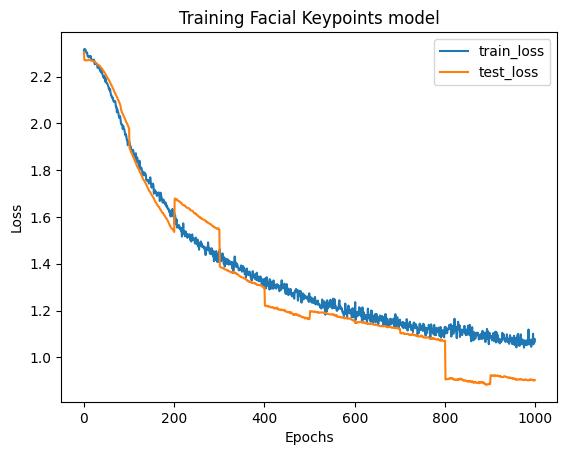

In [114]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()